In [28]:
import mxnet as mx
from mxnet import nd, autograd, gluon

### Set Context

In [29]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

### Build Dataset

In [30]:
num_inputs = 2
num_outputs = 1
num_examples = 10000

def real_fn(X):
    return 2*X[:,0] - 3.4*X[:,1] + 4.2

X = nd.random_normal(shape = (num_examples,num_inputs))
noise = 0.01*nd.random_normal(shape = (num_examples,))

y = real_fn(X)+noise

### Load the Data Iterator

In [31]:
batch_size = 4
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X,y)
                                  ,batch_size = batch_size
                                  , shuffle = True)

### Define the Model/Network Using Gluon

While it's good ot know how to build NN from scratch, we cane use gluon to compose an NN from **predefined node layers**.

For a linear model, the appropriate layer type is **Dense**. This is exactly a 'fully connected layer' where every node in the input is connected to every node in the subsequent layer.

In [32]:
#gluon.nn.Dense(self, units, activation=None, use_bias=True
#       , flatten=True, weight_initializer=None
#       , bias_initializer='zeros', in_units=0, **kwargs)

#Parameters (abbreviated)
#----------
#units : int
#    Dimensionality of the output space.
# in_units : int, optional
#     Size of the input data. If not specified, initialization will be
#     deferred to the first time `forward` is called and `in_units`
#     will be inferred from the shape of input data.

net = gluon.nn.Dense(units = 1, in_units = 2)

In [33]:
print net.weight
print net.bias

Parameter dense1_weight (shape=(1, 2), dtype=<type 'numpy.float32'>)
Parameter dense1_bias (shape=(1,), dtype=<type 'numpy.float32'>)


In [34]:
#View all Parameters of NN
print(net.collect_params())
print(type(net.collect_params()))

dense1_ (
  Parameter dense1_weight (shape=(1, 2), dtype=<type 'numpy.float32'>)
  Parameter dense1_bias (shape=(1,), dtype=<type 'numpy.float32'>)
)
<class 'mxnet.gluon.parameter.ParameterDict'>


In [36]:
#Access parameters the same was as using a dict
a=net.collect_params()
a.keys()

['dense1_weight', 'dense1_bias']

### Initialize Parameters (Deferred Initialization)

In [37]:
#Need to initialize values via gluon before running net
#    - This is done by calling the ParameterDict method .initialize() 
#    - This requires an initializer and a context for the parameters

net.collect_params().initialize(mx.init.Normal(sigma = 1.)
                               ,ctx = model_ctx)

#NOTE: This only associates each parameter with an initializer.
#    The actual initialization is deferred until the first forward
#    pass is executed


In [38]:
#This function call invokes the net's forward() method
example_data = nd.array([[4,7]])
net(example_data)


[[-11.15963078]]
<NDArray 1x1 @cpu(0)>

### Define Loss

In [39]:
square_loss = gluon.loss.L2Loss()

### Optimizer Using a gluon Trainer
Instead of writing stochastic gradient descent from scratch every time, we can instantiate a "gluon.Trainer", passing it a dictionary of parameters. 

In [41]:
trainer = gluon.Trainer(net.collect_params()
                       , 'sgd'
                       , {'learning_rate':0.0001}) 

### Execute a Training Loop

In [46]:
epochs = 20
loss_sequence = []
num_batches = num_examples/batch_size

for e in range(epochs):
    cumulative_loss = 0
    
    #inner loop
    for i, (data,label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        
        with autograd.record():
            #forward pass
            output = net(data)
            loss = square_loss(output,label)

        #backward pass
        loss.backward()
        
        #execute optimizer
        trainer.step(batch_size)
        
        cumulative_loss += nd.mean(loss).asscalar()
    
    #Progress
    print('Epoch %s, normalized_loss: %s' % (e,cumulative_loss/num_examples))
    loss_sequence.append(cumulative_loss)
        
        

Epoch 0, normalized_loss: 0.0202372727848
Epoch 1, normalized_loss: 0.0123278257982
Epoch 2, normalized_loss: 0.00751192544874
Epoch 3, normalized_loss: 0.00457952898539
Epoch 4, normalized_loss: 0.0027938602994
Epoch 5, normalized_loss: 0.00170660491722
Epoch 6, normalized_loss: 0.00104423639663
Epoch 7, normalized_loss: 0.000640835082722
Epoch 8, normalized_loss: 0.000395125843363
Epoch 9, normalized_loss: 0.000245529694608
Epoch 10, normalized_loss: 0.000154390844745
Epoch 11, normalized_loss: 9.8886670886e-05
Epoch 12, normalized_loss: 6.50722414267e-05
Epoch 13, normalized_loss: 4.44612520995e-05
Epoch 14, normalized_loss: 3.18912966587e-05
Epoch 15, normalized_loss: 2.42528067182e-05
Epoch 16, normalized_loss: 1.96013280604e-05
Epoch 17, normalized_loss: 1.67685518525e-05
Epoch 18, normalized_loss: 1.5050103391e-05
Epoch 19, normalized_loss: 1.399571383e-05


### Training Visualization

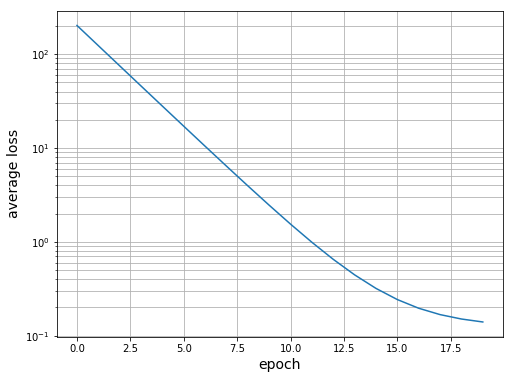

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (8,6))
plt.plot(loss_sequence)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)
plt.yscale('log')

### Accessing the Learned Model Parameters

Since we generated the data from a Gaussian linear regression model, we want to make sure that the learner managed to recover the model parameters, which were set to weight 2,−3.4 with an offset of 4.2.

In [48]:
params = net.collect_params()

for param in params.values():
    print(param.name,param.data())

('dense1_weight', 
[[ 1.99819124 -3.39892411]]
<NDArray 1x2 @cpu(0)>)
('dense1_bias', 
[ 4.19755602]
<NDArray 1 @cpu(0)>)


In [50]:
?loss.backward()